Copyright @ cb_park@korea.ac.kr (Cheonbok Park), joonleesky@kaist.ac.kr (Hojoon Lee)

## Installation Pytorch 

### Installation PyTorch following link: https://pytorch.org/
### We recommend installing the PyTorch GPU version

#### Launch terminal and activate assn1 virtual env
```bash
python -m pip install torch
python -m pip install torchvision
```

## MNIST Feed-Forward Neural Network

In [3]:
import torch 
import torch.nn as nn #
import torch.nn.functional as F # various activation functions for model
import torchvision # You can load various Pretrained Model from this package 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T # Transformation functions to manipulate images
import torch.optim as optim # various optimization functions for model
from torch.autograd import Variable 
from torch.utils import data

## Initilaize Data Loader

In [4]:
def MNIST_DATA(root='./',train =True,transforms=None ,download =True,batch_size = 32,num_worker = 1):
    print ("[+] Get the MNIST DATA")
    """
    We will use Mnist data for our tutorial 
    """
    mnist_train = vision_dsets.MNIST(root = root,  #root is the place to store your data. 
                                    train = True,  
                                    transform = T.ToTensor(),
                                    download=download)
    mnist_test = vision_dsets.MNIST(root = root,
                                    train = False, 
                                    transform = T.ToTensor(),
                                    download=download)
    """
    Data Loader is a iterator that fetches the data with the number of desired batch size. 
    * Practical Guide : What is the optimal batch size? 
      - Usually.., higher the batter. 
      - We recommend to use it as a multiple of 2 to efficiently utilize the gpu memory. (related to bit size)
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # information about your data type
                                      batch_size = batch_size, # batch size
                                      shuffle =True, # Whether to shuffle your data for every epoch. (Very important for training performance)
                                      num_workers = 1) # number of workers to load your data. (usually number of cpu cores)

    testDataLoader = data.DataLoader(dataset = mnist_test, 
                                    batch_size = batch_size,
                                    shuffle = False, # we don't actually need to shuffle data for test
                                    num_workers = 1) #
    print ("[+] Finished loading data & Preprocessing")
    return mnist_train,mnist_test,trainDataLoader,testDataLoader

In [5]:
# If the download fails, you can try the following code. 
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz
trainDset,testDset,trainDataLoader,testDataLoader= MNIST_DATA(batch_size = 32, download = True)  # Data Loader 

1.7%

[+] Get the MNIST DATA


100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


102.8%
7.7%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100.0%
112.7%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

[+] Finished loading data & Preprocessing


## Define Trainer

## Question 1 and 2 are in the remark of Trainer class

In [6]:
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):
        """
        trainloader: train data's loader
        testloader: test data's loader
        net: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch = 1):
        """
        epoch: number of times each training sample is used
        """
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, data in enumerate(self.trainloader, 0): 
                # get the inputs
                inputs, labels = data # Return type for data in dataloader is tuple of (input_data, labels)
                inputs = inputs.cuda()
                labels = labels.cuda()
                # zero the parameter gradients
                self.optimizer.zero_grad()    

                #########################################################
                #                                                       #
                # Question 1) what if we dind't clear up the gradients? #
                #                                                       #
                #########################################################
                
                # forward + backward + optimize
                outputs = self.net(inputs) # get output after passing through the network
                loss = self.criterion(outputs, labels) # compute model's score using the loss function 
                loss.backward() # perform back-propagation from the loss
                self.optimizer.step() # perform gradient descent with given optimizer

                # print statistics
                running_loss += loss.item()
                if (i+1) % 500 == 0:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                    running_loss = 0.0

        print('Finished Training')
        
    def test(self):
        self.net.eval() 

        ################################################################
        #                                                              #
        # Question 2) Why should we change the network into eval-mode? #
        #                                                              #
        ################################################################
        
        test_loss = 0
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()

            test_loss /= len(self.testloader.dataset)
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))

## Let's create Model by yourself

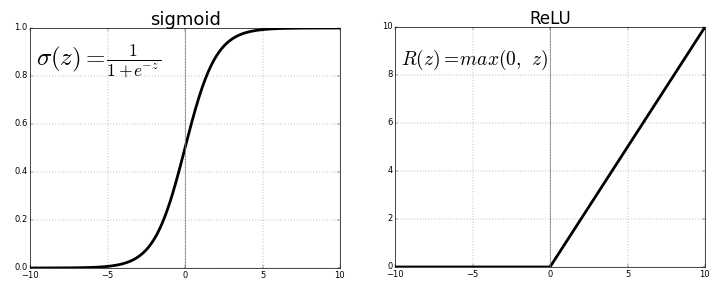

### Exp (1) 2-Layer Network + Sigmoid

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [7]:
class MNIST_Net(nn.Module): 
    def __init__(self):
        super(MNIST_Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) # x.view convert the shape of tensor, (Batch_size,28,28) --> (Batch_size,28*28)
        x = self.fc0(x) # 28*28 -> 30 
        x = torch.sigmoid(x) # Activation function 
        x = self.fc1(x)  # 30 -> 10, logit for each class
        return x

In [8]:
mnist_net = MNIST_Net().cuda() # create the neural network instance and load to the cuda memory.
criterion = nn.CrossEntropyLoss() # Define Loss Function. We use Cross-Entropy loss.
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer receives training parameters and learning rate.

In [9]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [10]:
trainer.train(epoch = 4)

[1,   500] loss: 2.349
[1,  1000] loss: 2.309
[1,  1500] loss: 2.287
[2,   500] loss: 2.262
[2,  1000] loss: 2.248
[2,  1500] loss: 2.234
[3,   500] loss: 2.213
[3,  1000] loss: 2.199
[3,  1500] loss: 2.185
[4,   500] loss: 2.157
[4,  1000] loss: 2.140
[4,  1500] loss: 2.124
Finished Training


In [11]:
trainer.test()


Test set:  Accuracy: 5489/10000 (55%)



### Exp (2) 2-Layer Network + ReLU

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

In [12]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) # Activation function
        x = self.fc1(x)  # 30 -> 10
        return x

In [13]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

In [14]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [15]:
trainer.train(epoch = 4)

[1,   500] loss: 2.257
[1,  1000] loss: 2.153
[1,  1500] loss: 2.029
[2,   500] loss: 1.778
[2,  1000] loss: 1.630
[2,  1500] loss: 1.467
[3,   500] loss: 1.227
[3,  1000] loss: 1.111
[3,  1500] loss: 1.009
[4,   500] loss: 0.873
[4,  1000] loss: 0.824
[4,  1500] loss: 0.775
Finished Training


In [16]:
trainer.test()


Test set:  Accuracy: 8470/10000 (85%)



## Question 3) Is there any difference in performance according to the activiation function?

### Exp (3) 3-Layer Network + Sigmoid

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [17]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = torch.sigmoid(x)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x

In [18]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)  

In [19]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [20]:
trainer.train(epoch = 4)

/home/ec2-user/anaconda3/envs/assn1/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,   500] loss: 2.332
[1,  1000] loss: 2.314
[1,  1500] loss: 2.307
[2,   500] loss: 2.302
[2,  1000] loss: 2.301
[2,  1500] loss: 2.300
[3,   500] loss: 2.300
[3,  1000] loss: 2.299
[3,  1500] loss: 2.299
[4,   500] loss: 2.299
[4,  1000] loss: 2.298
[4,  1500] loss: 2.298
Finished Training


In [21]:
trainer.test()


Test set:  Accuracy: 1135/10000 (11%)



### Exp (4) 3-Layer Network + ReLU

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

In [22]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [23]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) 

In [24]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [25]:
trainer.train(epoch = 4)

[1,   500] loss: 2.304
[1,  1000] loss: 2.299
[1,  1500] loss: 2.290
[2,   500] loss: 2.267
[2,  1000] loss: 2.249
[2,  1500] loss: 2.224
[3,   500] loss: 2.160
[3,  1000] loss: 2.110
[3,  1500] loss: 2.039
[4,   500] loss: 1.884
[4,  1000] loss: 1.767
[4,  1500] loss: 1.640
Finished Training


In [26]:
trainer.test()


Test set:  Accuracy: 6264/10000 (63%)



## Question 4) Is training gets done easily in experiment (3),(4) compared to experiment (1),(2)? If it doesn't, why not?

## Question 5) What would happen if there is no activation function?

## Let's Change our Optimizer

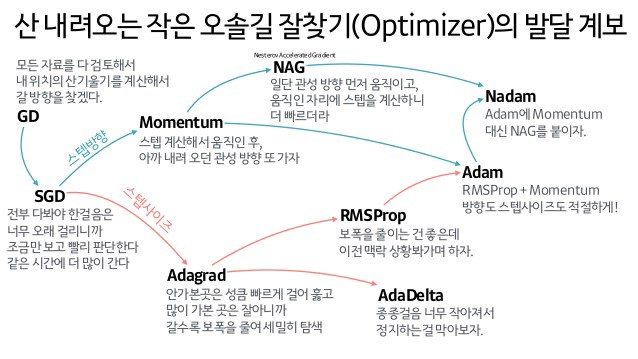

Reference: 하용호, 자습해도 모르겠던 딥러닝, 머리속에 인스톨 시켜드립니다

### Exp (5) 3-Layer Network + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

In [27]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [28]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [29]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [30]:
trainer.train(epoch = 4)

[1,   500] loss: 0.647
[1,  1000] loss: 0.310
[1,  1500] loss: 0.242
[2,   500] loss: 0.193
[2,  1000] loss: 0.169
[2,  1500] loss: 0.156
[3,   500] loss: 0.125
[3,  1000] loss: 0.130
[3,  1500] loss: 0.121
[4,   500] loss: 0.093
[4,  1000] loss: 0.097
[4,  1500] loss: 0.098
Finished Training


In [31]:
trainer.test()


Test set:  Accuracy: 9675/10000 (97%)



### Exp (6) 2-Layer Network + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

In [32]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) 
        x = self.fc1(x) 
        return x

In [33]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [34]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [35]:
trainer.train(epoch = 4)

[1,   500] loss: 0.680
[1,  1000] loss: 0.321
[1,  1500] loss: 0.279
[2,   500] loss: 0.222
[2,  1000] loss: 0.213
[2,  1500] loss: 0.208
[3,   500] loss: 0.181
[3,  1000] loss: 0.177
[3,  1500] loss: 0.170
[4,   500] loss: 0.152
[4,  1000] loss: 0.147
[4,  1500] loss: 0.159
Finished Training


In [36]:
trainer.test()


Test set:  Accuracy: 9577/10000 (96%)



## Batch-Normalization

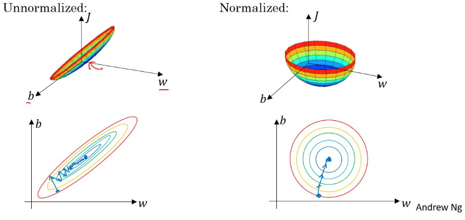

Reference: Andrew Ng, Deep Learning

### Exp (7) 2-Layer Network + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [37]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.bn0 = nn.BatchNorm1d(30) # BatchNorm 
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = self.bn0(x)
        x = F.relu(x) 
        x = self.fc1(x)   
        return x

In [38]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)  

In [39]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [40]:
trainer.train(epoch = 4)

[1,   500] loss: 0.695
[1,  1000] loss: 0.341
[1,  1500] loss: 0.280
[2,   500] loss: 0.214
[2,  1000] loss: 0.204
[2,  1500] loss: 0.202
[3,   500] loss: 0.170
[3,  1000] loss: 0.168
[3,  1500] loss: 0.162
[4,   500] loss: 0.152
[4,  1000] loss: 0.145
[4,  1500] loss: 0.151
Finished Training


In [41]:
trainer.test()


Test set:  Accuracy: 9599/10000 (96%)



### Exp (8) 3-Layer Network + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [42]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.bn0 = nn.BatchNorm1d(50) # BatchNorm 1 
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.bn1 = nn.BatchNorm1d(30) # BatchNorm 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [43]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [44]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [45]:
trainer.train(epoch = 4)

[1,   500] loss: 0.646
[1,  1000] loss: 0.246
[1,  1500] loss: 0.193
[2,   500] loss: 0.150
[2,  1000] loss: 0.137
[2,  1500] loss: 0.141
[3,   500] loss: 0.112
[3,  1000] loss: 0.112
[3,  1500] loss: 0.114
[4,   500] loss: 0.086
[4,  1000] loss: 0.097
[4,  1500] loss: 0.095
Finished Training


In [46]:
trainer.test()


Test set:  Accuracy: 9768/10000 (98%)



## Question 6) Is there any performance difference before/after applying the batch-norm?

## HW 1.1 Let's Do It: Let's achieve performance greater than 97%!

In [ ]:
# TODO  

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()

    def forward(self, x):
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [ ]:
train_network(mnist_net,optimizer,trainDataLoader)

In [ ]:
test(mnist_net,testDataLoader)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(mnist_net)

## Question 7) What may be the potential problems when training the neural network with a large number of parameters?

## Let's use Convolution Layer

### Convolution Operation

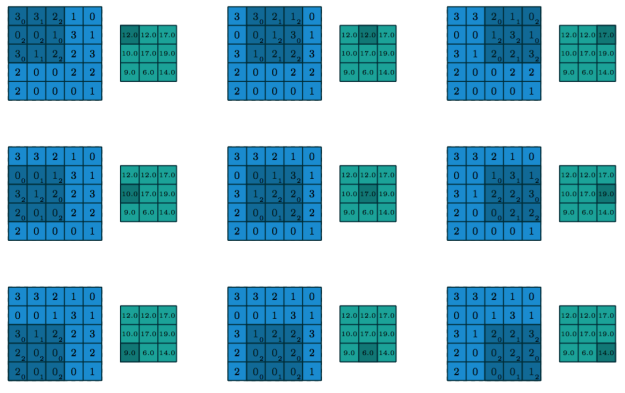

## Question 8) Given input image with shape:(H, W, C1), what would be the shape of output image after applying two convolutional filters with stride S and size F * F? 

### (9) 3-Layer Network (Conv+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (6 * 6) filter with stride=2 
- Hidden dimension: 8 * 12 * 12
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [47]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  # 2d batch-norm is used in 3d inputs
        self.fc = nn.Linear(8*12*12, 10)   # Layer 2 

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [48]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [49]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [50]:
trainer.train(epoch = 4)

[1,   500] loss: 0.390
[1,  1000] loss: 0.171
[1,  1500] loss: 0.130
[2,   500] loss: 0.089
[2,  1000] loss: 0.086
[2,  1500] loss: 0.081
[3,   500] loss: 0.069
[3,  1000] loss: 0.065
[3,  1500] loss: 0.059
[4,   500] loss: 0.053
[4,  1000] loss: 0.055
[4,  1500] loss: 0.055
Finished Training


In [51]:
trainer.test()


Test set:  Accuracy: 9808/10000 (98%)



In [52]:
count_parameters(mnist_net)

NameError: name 'count_parameters' is not defined

## Question 9) How did the performance and the number of parameters change after using the Convolution operation? Why did these results come out?

### (10) 3-Layer Network (Conv+Pool+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (7 * 7) filter with stride=2 
- Pool: 2 * 2
- Hidden dimension: 8 * 6 * 6
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

### Pooling Operation

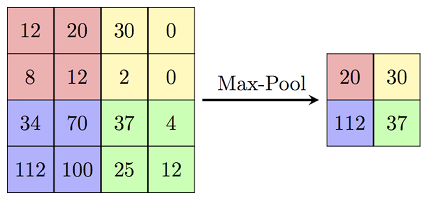

In [53]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  
        self.pool0 = nn.MaxPool2d(2)
        self.fc = nn.Linear(8*6*6, 10) 

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [54]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [55]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [56]:
trainer.train(epoch = 4)

[1,   500] loss: 0.534
[1,  1000] loss: 0.197
[1,  1500] loss: 0.143
[2,   500] loss: 0.110
[2,  1000] loss: 0.098
[2,  1500] loss: 0.095
[3,   500] loss: 0.082
[3,  1000] loss: 0.078
[3,  1500] loss: 0.075
[4,   500] loss: 0.070
[4,  1000] loss: 0.070
[4,  1500] loss: 0.073
Finished Training


In [57]:
trainer.test()


Test set:  Accuracy: 9784/10000 (98%)



In [58]:
count_parameters(mnist_net)

NameError: name 'count_parameters' is not defined

## Question 10) How did the performance change after using the Pooling operation? Why did these results come out?